In [4]:
import pandas as pd

In [5]:
df = pd.read_csv('../data/housing.csv')

In [6]:
df.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY


In [7]:
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [8]:
df = df[['latitude', 'longitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity']]

In [9]:
df.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,35.631861,-119.569704,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.135952,2.003532,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,32.540000,-124.350000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,33.930000,-121.800000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,34.260000,-118.490000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,37.710000,-118.010000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,41.950000,-114.310000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [10]:
# let's model median_house_value as our target variable
# I'll pick these six features
# I don't think lat and long will be useful for a linear model,
# and I will omit the string column ocean_proximity
features = ['housing_median_age', 'total_rooms','total_bedrooms',
            'population', 'households', 'median_income']
target = ['median_house_value']

In [11]:
# drop columns we won't use
df = df[features+target]

In [12]:
# drop rows with missing data in one of the remaining columns
df = df.dropna()

In [13]:
# let's do a train-val-test split
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(df[features],
                                                 df[target],
                                                 test_size = 0.4,
                                                 random_state = 0)

In [14]:
x_val,x_test,y_val,y_test = train_test_split(x_test,
                                             y_test,
                                             test_size = 0.5,
                                             random_state = 0)

In [15]:
len(x_train)/len(x_test)

2.9995106435037924

In [16]:
from sklearn.linear_model import LinearRegression

In [17]:
lr = LinearRegression()

In [18]:
lr.fit(x_train,y_train)
lr.score(x_val,y_val)

0.5614677159523239

In [19]:
# let's look at the coefficients
for _ in zip(features,lr.coef_[0]):
    print(_[0],_[1])


housing_median_age 1866.0512948368803
total_rooms -18.6044215098864
total_bedrooms 98.40287632209355
population -32.80233615787482
households 113.49421027982164
median_income 47133.06363115725


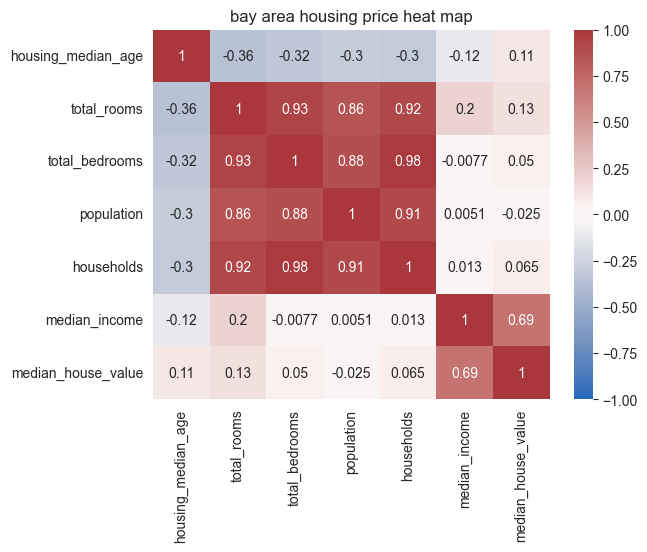

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
fig,ax = plt.subplots()
ax = sns.heatmap(df.corr(),vmin=-1,vmax=1,cmap="vlag",annot = True)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_yticklabels(ax.get_yticklabels(),rotation=0)
ax.set_title('bay area housing price heat map');

In [21]:
from itertools import combinations

In [22]:
coef_dct = dict(zip(features,[[],[],[],[],[],[]]))

In [23]:
for i in range(1,len(features)+1):
    for feature_subset in combinations(features,i):
        feature_subset = list(feature_subset)
        df_tmp = df[feature_subset+target]
        df_tmp = df_tmp.dropna()
        x_train,x_test,y_train,y_test = train_test_split(df_tmp[feature_subset],
                                                         df_tmp[target],
                                                         test_size = 0.4,
                                                         random_state = 0)
        x_val,x_test,y_val,y_test = train_test_split(x_test,
                                                     y_test,
                                                     test_size = 0.5,
                                                     random_state = 0)
        lr = LinearRegression()
        lr.fit(x_train,y_train)
        lr.score(x_val,y_val)
        for item in zip(feature_subset, lr.coef_[0]):
            coef_dct[item[0]].append(item[1])

In [24]:
df_coef = pd.DataFrame(coef_dct)

In [25]:
features

['housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

<Axes: >

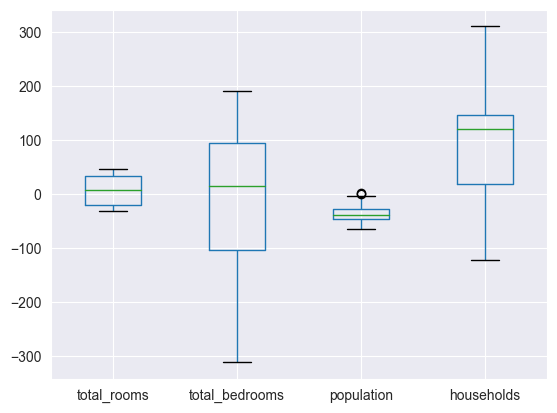

In [26]:
df_coef[features[1:-1]].boxplot()

In [27]:
# the wild fluctuation in coefficients per feature proves the features are dependent.
# the boxplot shows the impact of feature dependence on our ability to interpret a linear
# model.
# we will do feature engineering to produce a set of six independent features from the
# given feature set.
# specifically, we'll use Principal Component Analysis (PCA)
# PCA assumed the variables are jointly normally distributed.


In [28]:
from sklearn.decomposition import PCA

In [29]:
pca = PCA(n_components=6) # controls how many principal components are returned
# this gives us an object we can fit to some data

In [30]:
pca.fit(x_train)

PCA(n_components=6)

In [31]:
print(pca.explained_variance_ratio_)

[9.48715257e-01 4.57776020e-02 5.06970923e-03 4.14916270e-04
 2.21267496e-05 3.88656987e-07]


In [32]:
# this looks too good to be true because it is. we didn't normalize our data.
# that trivializes the variation found in variables relatively smaller scales

In [33]:
df.describe()

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000
mean,28.633094,2636.504233,537.870553,1424.946949,499.433465,3.871162,206864.413155
std,12.591805,2185.269567,421.385070,1133.208490,382.299226,1.899291,115435.667099
min,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,18.000000,1450.000000,296.000000,787.000000,280.000000,2.563700,119500.000000
50%,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.536500,179700.000000
75%,37.000000,3143.000000,647.000000,1722.000000,604.000000,4.744000,264700.000000
max,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [34]:
# let's normalize the data first
from sklearn import preprocessing

In [35]:
scaler = preprocessing.StandardScaler()

In [36]:
# I fit the scaler to my training data
scaler.fit(x_train)

StandardScaler()

In [37]:
x_train.head()

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
9490,17.0,3145.0,693.0,1560.0,647.0,2.2926
3191,24.0,544.0,112.0,442.0,106.0,3.1071
9896,10.0,969.0,160.0,482.0,180.0,6.5799
8042,36.0,1348.0,234.0,643.0,221.0,3.6447
10421,31.0,3959.0,856.0,1919.0,775.0,4.0313


In [38]:
pd.DataFrame(scaler.transform(x_train)).describe()

,0,1,2,3,4,5
count,1.225900e+04,1.225900e+04,1.225900e+04,1.225900e+04,1.225900e+04,1.225900e+04
mean,-8.288409e-17,-1.391062e-17,-1.112849e-16,-1.391062e-17,-4.289107e-17,-1.669274e-16
std,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00
min,-2.197477e+00,-1.225269e+00,-1.288604e+00,-1.271057e+00,-1.317843e+00,-1.766758e+00
25%,-8.473965e-01,-5.456467e-01,-5.781802e-01,-5.641078e-01,-5.755344e-01,-6.838435e-01
50%,2.618497e-02,-2.329601e-01,-2.445689e-01,-2.298973e-01,-2.347594e-01,-1.732688e-01
75%,6.615170e-01,2.305984e-01,2.618483e-01,2.673864e-01,2.803655e-01,4.554746e-01
max,1.852764e+00,1.708331e+01,1.361350e+01,3.069577e+01,1.283356e+01,5.855434e+00


In [39]:
x_train_sc = scaler.transform(x_train)

In [40]:
# fits the PCA to the scaled data
pca = PCA()
pca.fit(x_train_sc)

PCA()

In [41]:
print(pca.explained_variance_ratio_)

[0.64560233 0.17811116 0.1363209  0.02607035 0.01146702 0.00242823]


In [42]:
# exercise: see how the coefficients of the PCs vary in linear models
# trained on all subsets of PCs.
pca_features = ['pc'+str(i) for i in range(1,7)]
df_pca = pd.DataFrame(pca.transform(x_train_sc),columns = pca_features)
coef_dct = dict(zip(pca_features,[[],[],[],[],[],[]]))

In [43]:
for i in range(1,len(pca_features)+1):
    for feature_subset in combinations(pca_features,i):
        feature_subset = list(feature_subset)
        df_tmp = df_pca[feature_subset]
        df_tmp = df_tmp.dropna()
        lr = LinearRegression()
        lr.fit(df_tmp,y_train)
        lr.score(pd.DataFrame(pca.transform(scaler.transform(x_val)),columns=pca_features)[feature_subset],
                 y_val)
        for item in zip(feature_subset, lr.coef_[0]):
            coef_dct[item[0]].append(item[1])

In [45]:
pd.DataFrame(coef_dct)

,pc1,pc2,pc3,pc4,pc5,pc6
0,3729.771042,61453.696335,57019.918528,-38656.149322,-80516.639807,6014.28991
1,3729.771042,61453.696335,57019.918528,-38656.149322,-80516.639807,6014.28991
2,3729.771042,61453.696335,57019.918528,-38656.149322,-80516.639807,6014.28991
3,3729.771042,61453.696335,57019.918528,-38656.149322,-80516.639807,6014.28991
4,3729.771042,61453.696335,57019.918528,-38656.149322,-80516.639807,6014.28991
5,3729.771042,61453.696335,57019.918528,-38656.149322,-80516.639807,6014.28991
6,3729.771042,61453.696335,57019.918528,-38656.149322,-80516.639807,6014.28991
7,3729.771042,61453.696335,57019.918528,-38656.149322,-80516.639807,6014.28991
8,3729.771042,61453.696335,57019.918528,-38656.149322,-80516.639807,6014.28991
9,3729.771042,61453.696335,57019.918528,-38656.149322,-80516.639807,6014.28991


In [58]:
# deductive feature selection to choose nbest list of fatures from original

# Make a copy of the list of features
fs = [feat for feat in features]
important_features = []

In [57]:
# train linear models on each subset of 5 from fs
res= []
for comb in combinations(features,5):
    missing = [_ for _ in features if _ not in list(fs)][0]
    comb = list(fs)
    lr.fit(x_train[fs], y_train)
    score = lr.score(x_test[fs], y_test)
    res.append((missing, score))
res

[('housing_median_age', 0.5525475711947789),
 ('housing_median_age', 0.5525475711947789),
 ('housing_median_age', 0.5525475711947789),
 ('housing_median_age', 0.5525475711947789),
 ('housing_median_age', 0.5525475711947789),
 ('housing_median_age', 0.5525475711947789)]

In [56]:
# getting least valuable feature from highest value score
least_important = max(res, key=lambda t:t[1])[0]

'total_bedrooms'

In [62]:
# iterating everyting above
fs = [feat for feat in features]
imoportant_features = []
while len(fs) > 1:
    if len(fs) == 1:
        important_features.insert(0,fs[0])
        break
    res= []
    for comb in combinations(fs,len(fs)-1):
        missing = [_ for _ in fs if _ not in list(comb)][0]
        comb = list(comb)
        lr.fit(x_train[comb], y_train)
        score = lr.score(x_test[comb], y_test)
        res.append((missing, score))
    least_important = max(res, key=lambda t:t[1])[0]
    important_features.insert(0,least_important)
    fs.remove(least_important)

In [65]:
important_features

['median_income',
 'housing_median_age',
 'households',
 'population',
 'total_rooms',
 'total_bedrooms']

In [66]:
acc = []
for i in range(1, len(important_features)+1):
    lr.fit(x_train[important_features[:i]],y_train)
    acc.append(lr.score(x_val[important_features[:i]], y_val))

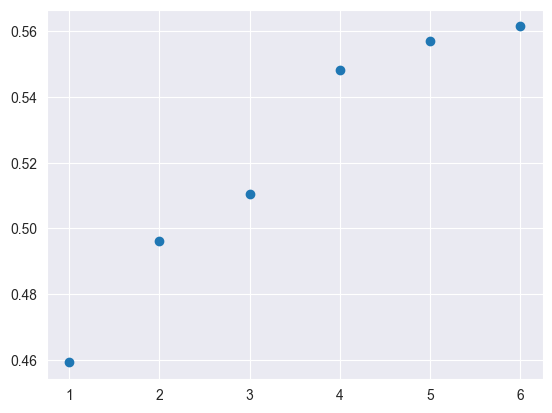

In [67]:
fig, ax = plt. subplots()
ax.scatter(range(1,len(important_features)+1), acc)

In [69]:
# do he same with principal components
# iterating everyting above
pca_fs = [feat for feat in pca_features ]
pca_important_features = []
while len(pca_fs) > 1:
    if len(pca_fs) == 1:
        pca_important_features.insert(0,fs[0])
        break
    res= []
    for comb in combinations(pca_fs,len(pca_fs)-1):
        missing = [_ for _ in fs if _ not in list(comb)][0]
        comb = list(comb)
        lr.fit(pca.transform(x_train[comb]), y_train)
        score = lr.score(x_val[comb], y_val)
        res.append((missing, score))
    least_important = max(res, key=lambda t:t[1])[0]
    pca_important_features.insert(0,least_important)
    pca_fs.remove(least_important)

KeyError: "None of [Index(['pc1', 'pc2', 'pc3', 'pc4', 'pc5'], dtype='object')] are in the [columns]"

In [71]:
for i in range(1,7):
    scaler = preprocessing.StandardScaler()
    scaler.fit(x_train)
    x_train_sc = scaler.transform(x_train)
    pca = PCA(n_components=i)
    pca.fit(x_train_sc)
    lr.fit(pca.transform(x_train_sc), y_train)
    sc = lr.score(pca.transform(scaler.transform(x_val)), y_val)
    print(sc)

0.002870956050893936
0.2965501047632507
0.49770522302371756
0.5184982575279566
0.5615219099178583
0.561467715952324


In [ ]:
acc = []
for i in range(1, len(pca_features)+1):
    lr.fit(x_train[pca_features[:i]],y_train)
    acc.append(lr.score(x_val[important_features[:i]], y_val))